# Transfer Learning Pt 1: Feature Extraction

### What is transfer learning? 
Surely someone has spent the time crafting the right model for the job...
Why can't we use an already created cnn model that was trained on image net to work on our data, as well.
* we can get really good results in a fraction of the time by using an already created model rather than creating our own architecture.

Transfer learning is leveraging a working model's existing architecture and learned patters for our own problem.

The two main benefits:
1. can leverage an existing neural network architecutre proven to work on problems similar to our own
2. can leverage a working nn architecture which has already learned paters on similar data to our own, then we can adapt those patterns to our own data.

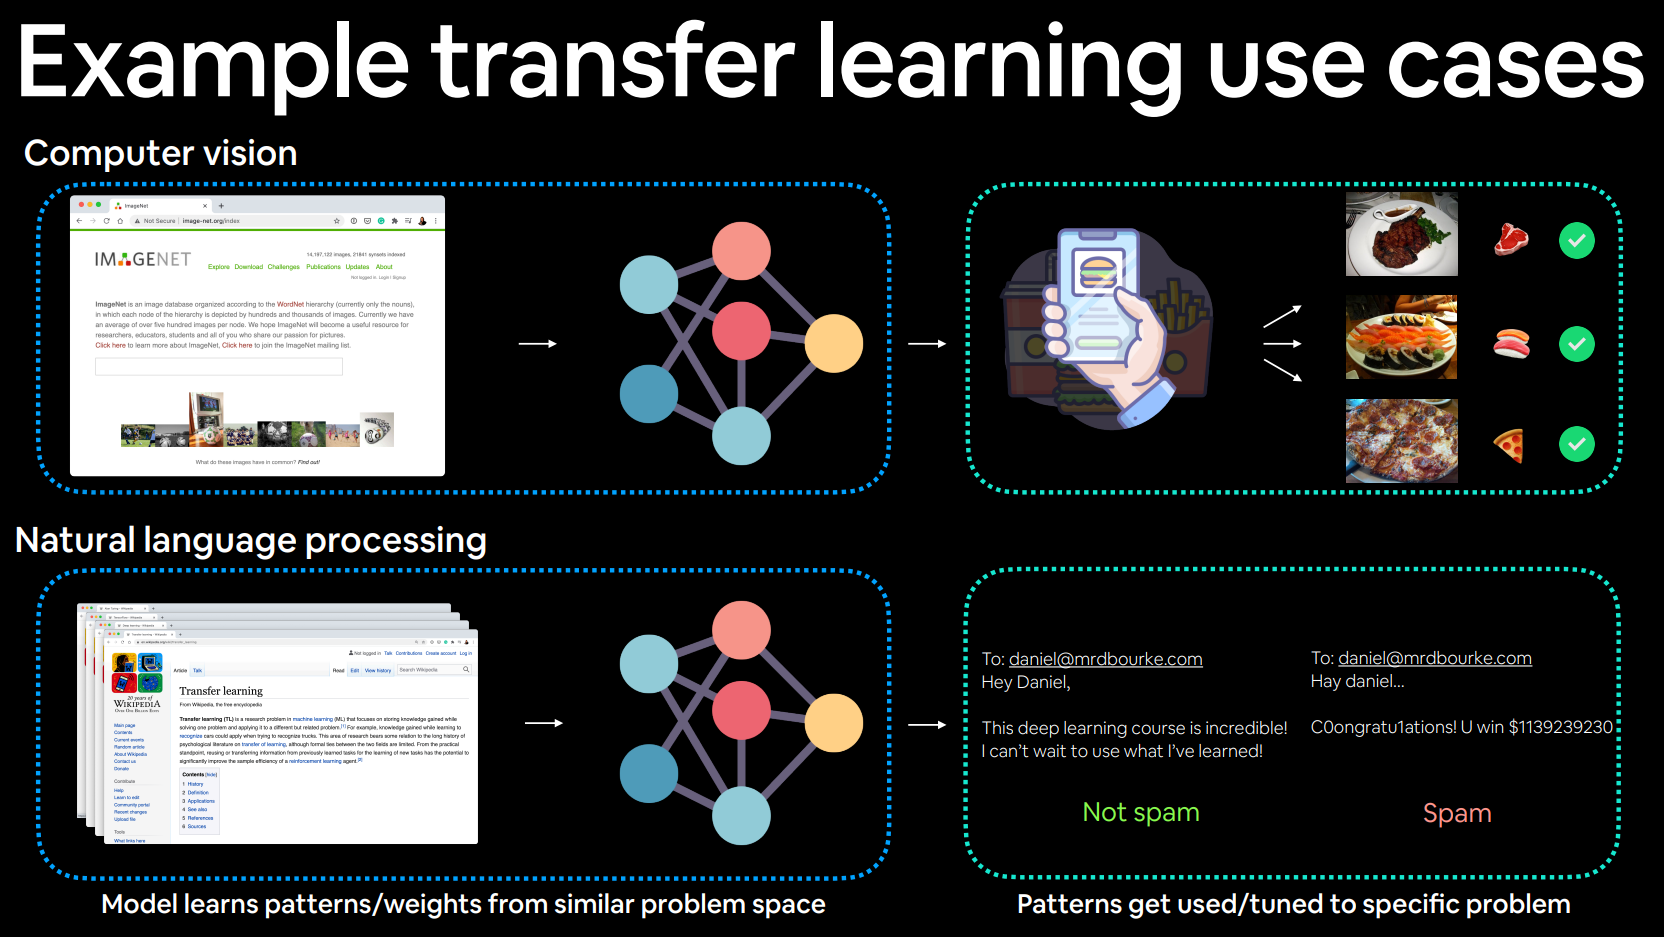

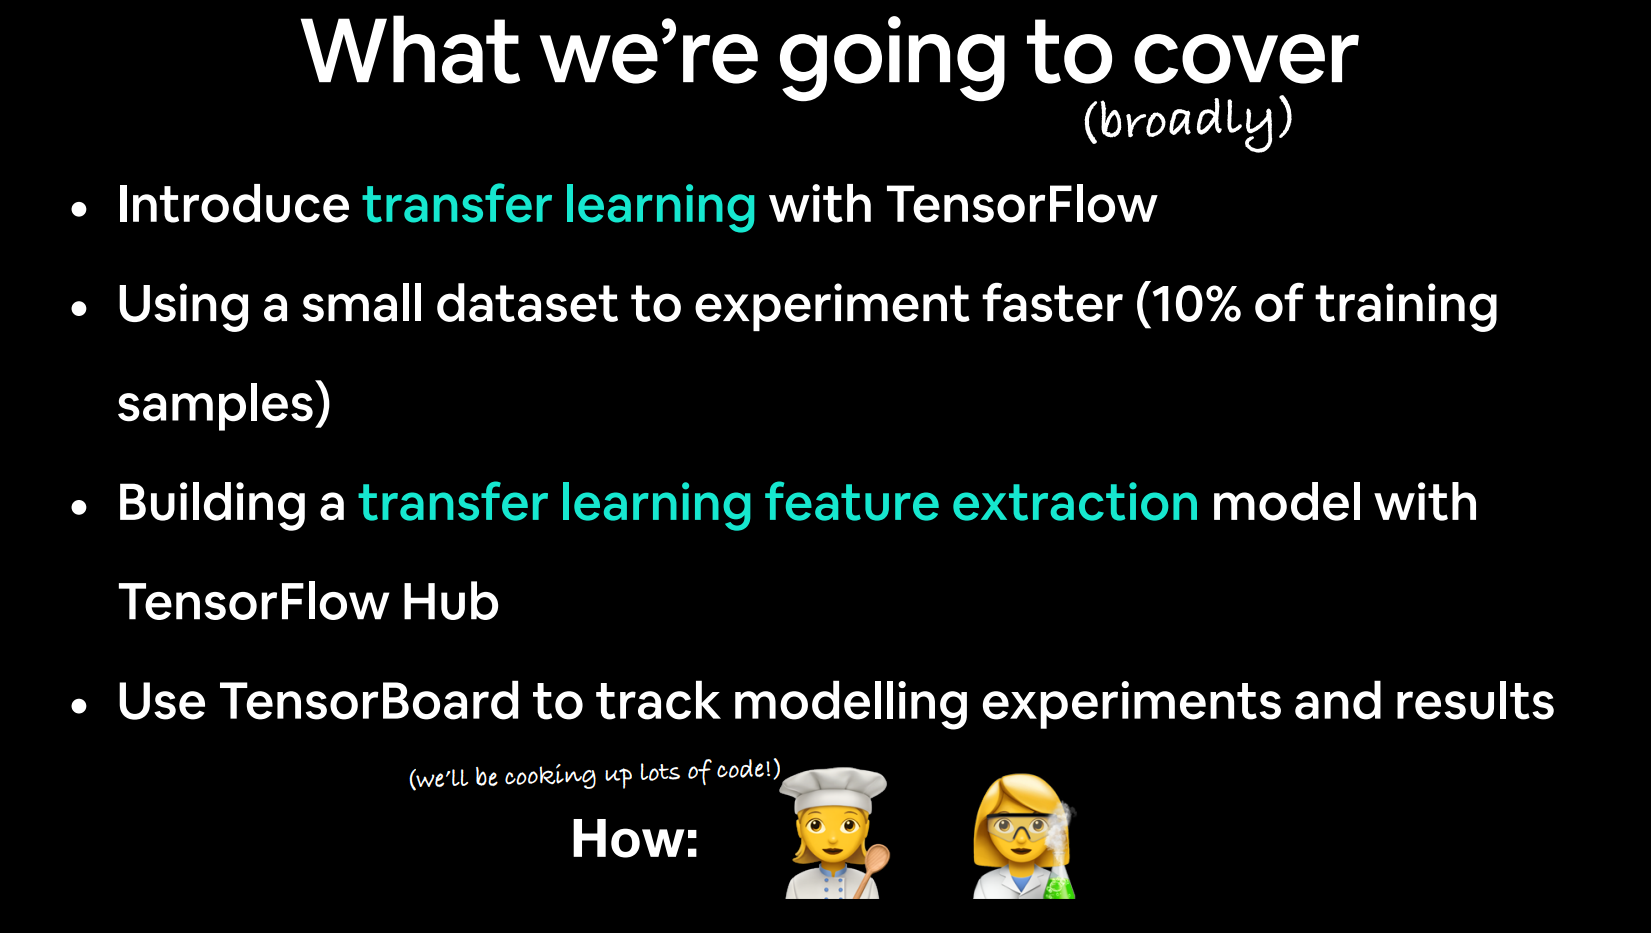

Are we using a gpus?

In [1]:
!nvidia-smi

Tue Aug  5 17:31:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.88                 Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:07:00.0  On |                  N/A |
| 30%   30C    P8             16W /  324W |     479MiB /  16376MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Downloading and preparing data for our first transfer learning model
we're using the same dataset as we've used in the last section with only 10% of the data.

In [2]:
#how many images in each folder
import tensorflow as tf
import os, pathlib
for dirpath, dirnames, filenames in os.walk('datasets/10_food_classes_10_percent/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in datasets/10_food_classes_10_percent/
There are 10 directories and 0 images in datasets/10_food_classes_10_percent/test
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\chicken_curry
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\chicken_wings
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\fried_rice
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\grilled_salmon
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\hamburger
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\ice_cream
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\pizza
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\ramen
There are 0 directories and 250 images in datasets/10_food_classes_10_percent/test\steak
Th

there are still 250 images in the test directories. 
However, there are only 75 images in each training class.

In [3]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """ 
    Returns seperate loss curves for training and validation metrics.
    Args:
        history: tf history object.
    
    Returns:
        plots of training/validation loss and accuracy metrics
    """
    #define vars
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    #plot the loss
    plt.figure()
    plt.plot(epochs, loss, label = 'loss')
    plt.plot(epochs, val_loss, label = 'val loss')
    plt.xlabel('epochs')
    plt.legend()
    #plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [4]:
#create data loaders (preparing the data)
#with use imagedatagenerator class to load in our images in batches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE  = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = 'datasets/10_food_classes_10_percent/train/'
test_dir = 'datasets/10_food_classes_10_percent/test/'


train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

print('train images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size = IMAGE_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical')

print('test images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

train images: 
Found 750 images belonging to 10 classes.
test images: 
Found 2500 images belonging to 10 classes.


#### Introducing Callbacks in TF and making a callback to track our models
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Tracking experiments with **TensorBoard** callback
* Model Checkpoint with **ModelCheckpoint** callback
* stopping a model from overfitting with **EarlyStopping** callback

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks


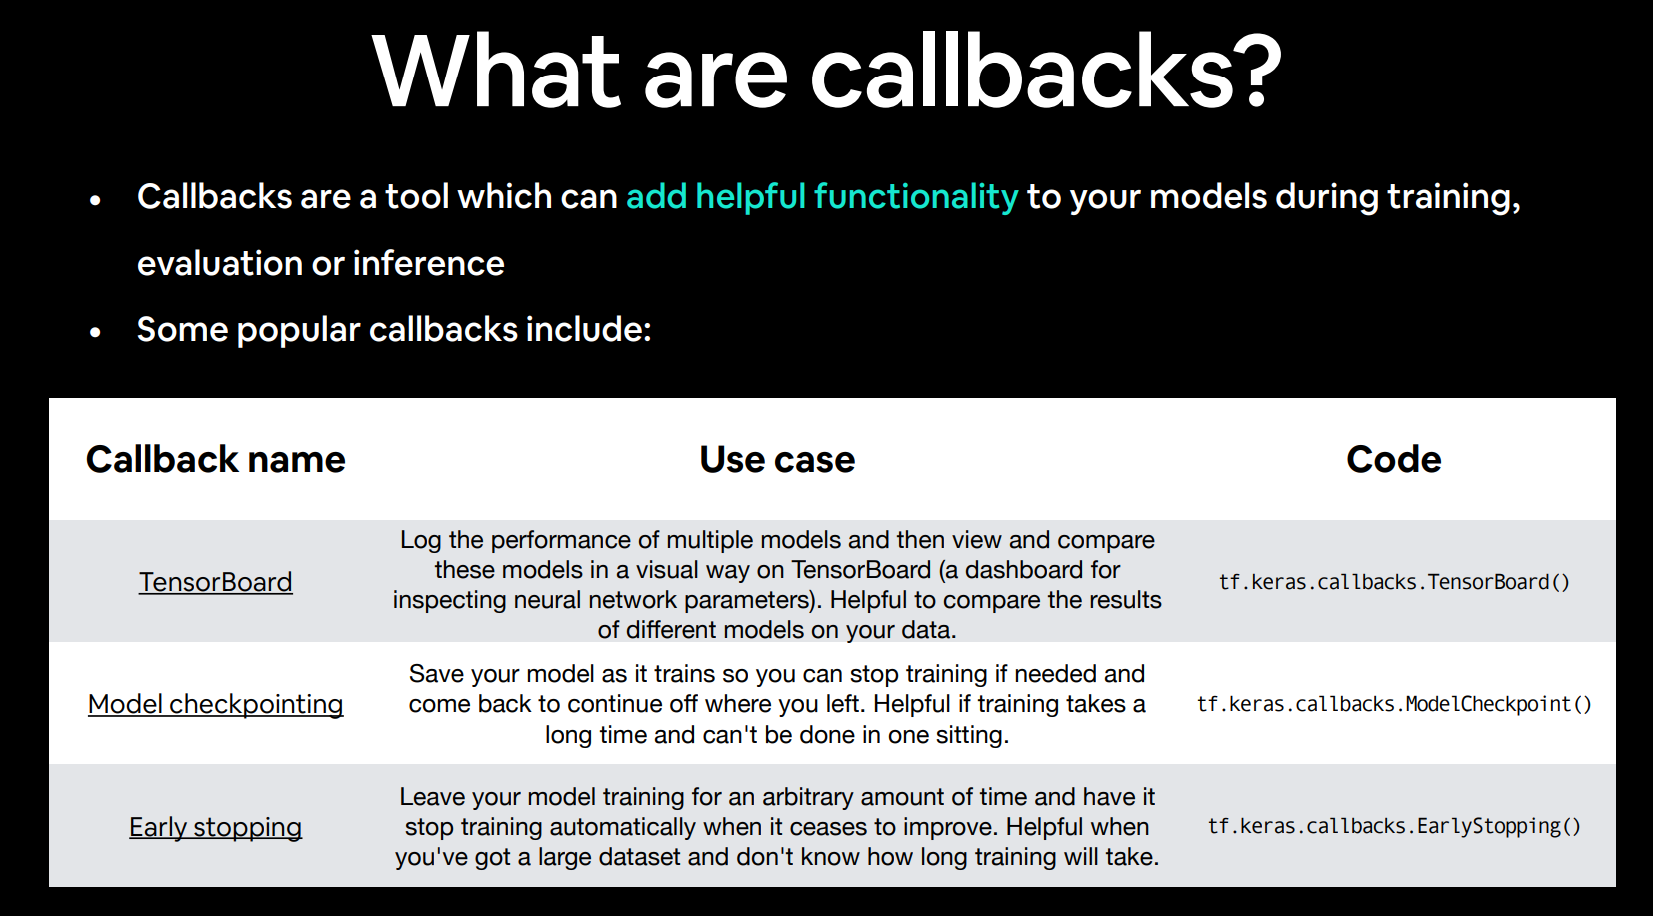

In [5]:
# set up tensorboard callback to help us track our experiments
#(functionized becuase we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f'saving tensorboard log files to: {log_dir}')
    return tensorboard_callback

#### Exploring TensorFlow Hub for pretrained models

In the past we've used tf to create our own models layer by layer from scratch. Now we're going to do a similar process, except the majority of our model's layers are going to come from tensorflow hub.
We can access pretrained models on: https://tfhub.dev/


Browsing the tf hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
#lets compare the results from two tf hub models resnet
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2'
efficientnet_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1'

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers



In [8]:
#function to create model from url
def create_model(model_url, num_classes = 10):
    """takes a tf hub url and creates a keras sequential model with it.
    args:
        model_url (str): A tf hub feature extraction url.
        num_classes (int): number of output neurons in the output layer, should be equal to the number of target classes.
        
    returns:
        an uncompiled keras sequential model with model_url as feature extractor layer and dense output layer with num_classes output neuron.
    """
    
    #download pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable = False, #freeze already learned patterns
                                            name = 'feature_extractor_layer',
                                            input_shape = IMAGE_SHAPE + (3,)) 

    #create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
    ])
    
    return model

#### Create resnet feature extraction model

In [9]:
#resnet model using function
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)
#this returns an uncompile model so we do have compile the model

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
#compile resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])

In [12]:
#fitting our model on 10 percent of the train data
resnet_history = resnet_model.fit(train_data_10_percent,
                    epochs = 5,
                    steps_per_epoch = len(train_data_10_percent),
                    validation_data = test_data,
                    validation_steps = len(test_data),
                    callbacks = [create_tensorboard_callback(dir_name = 'hub',
                                                            experiment_name = 'resnet50v2')])

saving tensorboard log files to: hub\resnet50v2\20250805-173228
Epoch 1/5
24/24 [==============================] - 27s 874ms/step - loss: 1.8807 - accuracy: 0.3907 - val_loss: 1.1449 - val_accuracy: 0.6408
Epoch 2/5
24/24 [==============================] - 8s 330ms/step - loss: 0.8816 - accuracy: 0.7227 - val_loss: 0.8237 - val_accuracy: 0.7412
Epoch 3/5
24/24 [==============================] - 8s 322ms/step - loss: 0.6075 - accuracy: 0.8173 - val_loss: 0.7405 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 7s 318ms/step - loss: 0.4704 - accuracy: 0.8867 - val_loss: 0.6871 - val_accuracy: 0.7788
Epoch 5/5
24/24 [==============================] - 8s 335ms/step - loss: 0.3820 - accuracy: 0.8947 - val_loss: 0.6640 - val_accuracy: 0.7888


Wow, a massive increase in accuracy and validation accuracy!!! much better!!! previous models with 100 percent of the data only got 30 percent accuracy for both training and validation data.

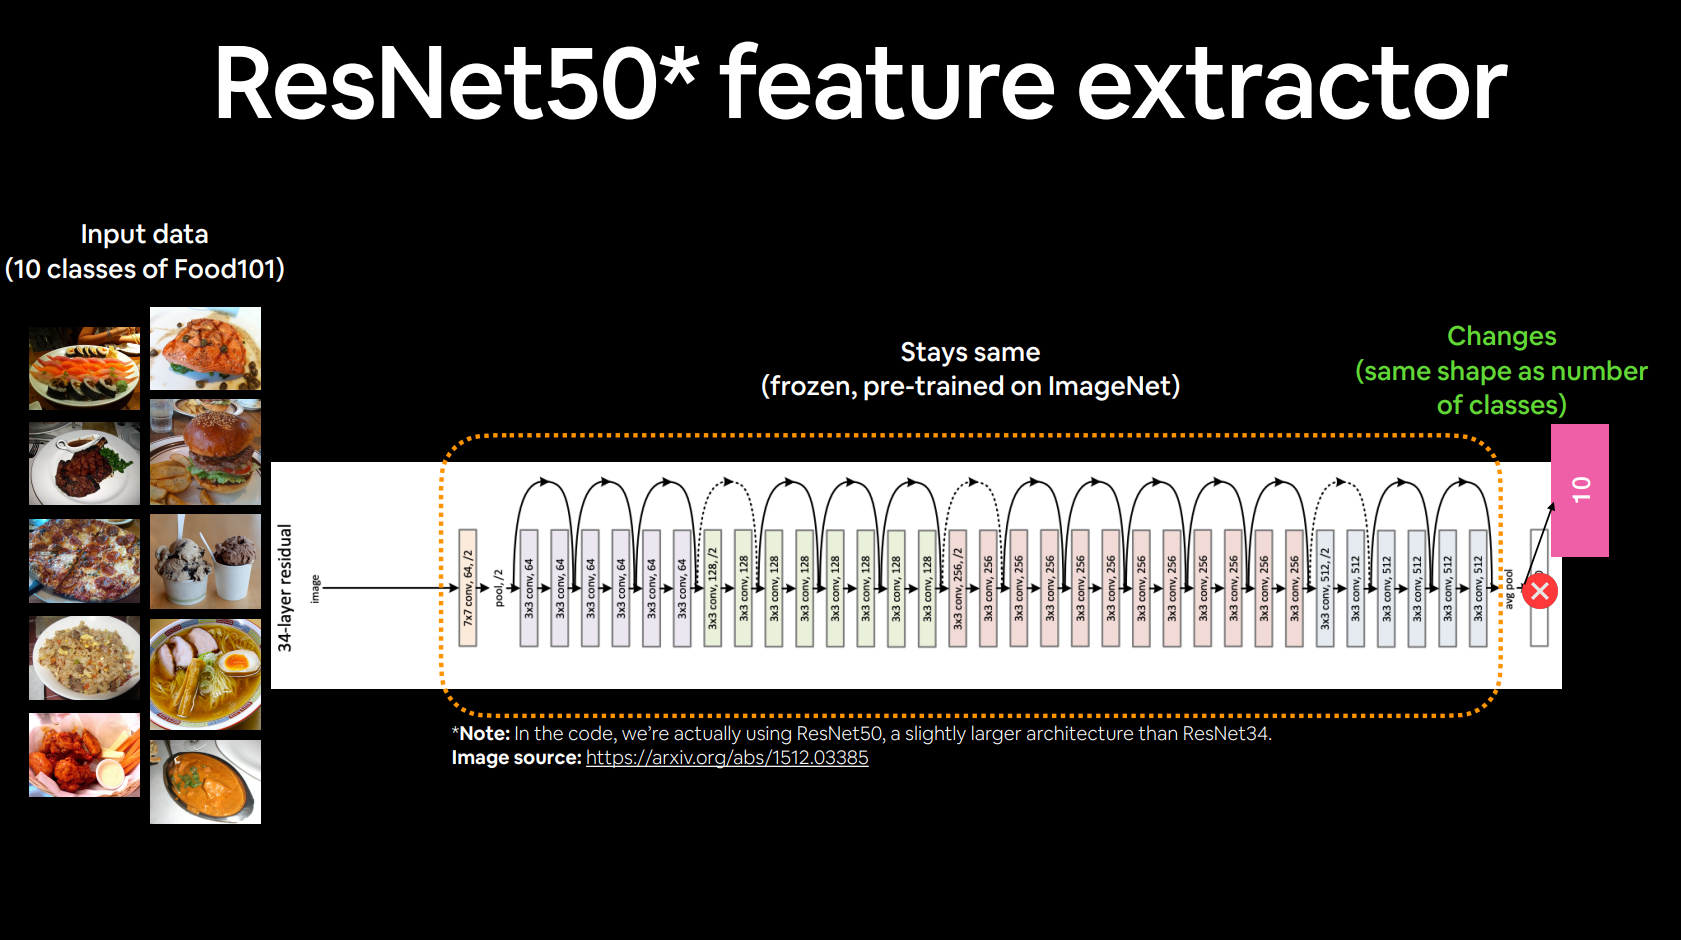

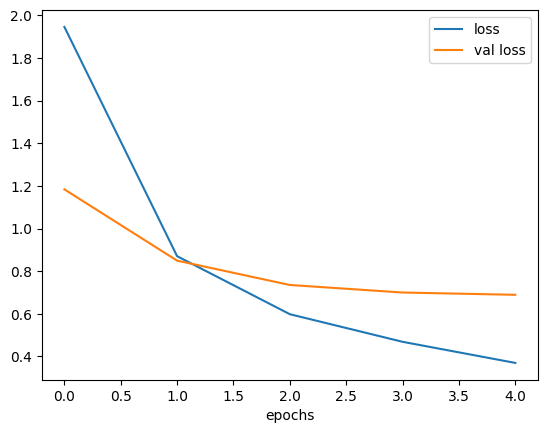

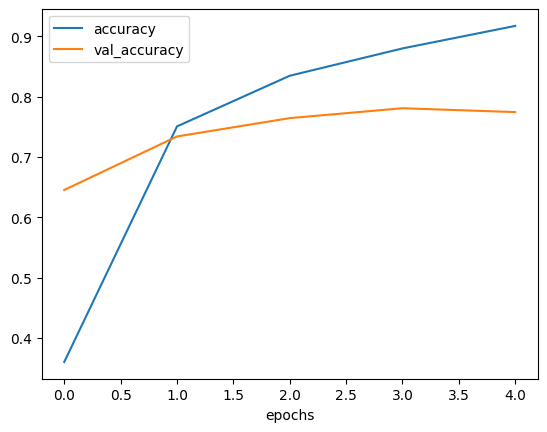

In [13]:
plot_loss_curves(resnet_history)

#### create EfficientNetB0 model to compare against the resnet model

In [13]:
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)

In [14]:
efficientnet_model.compile(loss = 'categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 5,
                                             steps_per_epoch = len(train_data_10_percent),
                                             validation_data = test_data,
                                             validation_steps = len(test_data),
                                             callbacks= [create_tensorboard_callback(dir_name = 'hub',
                                                                                    experiment_name = 'EfficientNetB0')])

saving tensorboard log files to: hub/EfficientNetB0/20250804-225913
Epoch 1/5
24/24 [==============================] - 8s 182ms/step - loss: 1.8556 - accuracy: 0.4533 - val_loss: 1.2985 - val_accuracy: 0.7472
Epoch 2/5
24/24 [==============================] - 4s 174ms/step - loss: 1.0538 - accuracy: 0.7813 - val_loss: 0.8634 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 4s 170ms/step - loss: 0.7482 - accuracy: 0.8293 - val_loss: 0.6972 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 4s 169ms/step - loss: 0.6044 - accuracy: 0.8707 - val_loss: 0.6104 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 4s 171ms/step - loss: 0.5111 - accuracy: 0.8893 - val_loss: 0.5584 - val_accuracy: 0.8596


damn, look at the accuracy/val_accuracy!!!

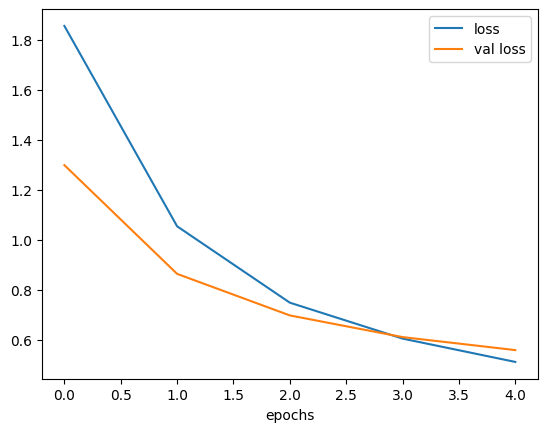

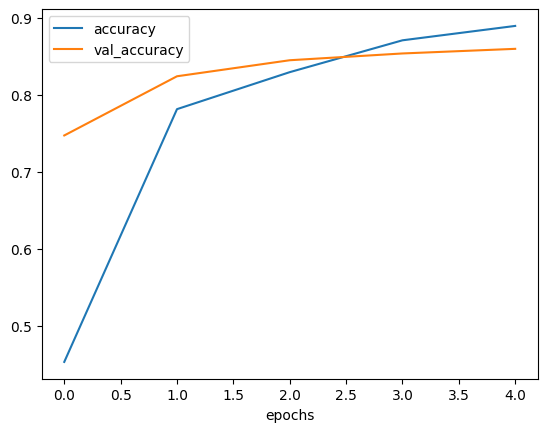

In [20]:
plot_loss_curves(efficientnet_history)

### efficientnet with early stopping


In [16]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

efficientnet_history2 = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 200,
                                             steps_per_epoch = len(train_data_10_percent),
                                             validation_data = test_data,
                                             validation_steps = len(test_data),
                                             callbacks= [create_tensorboard_callback(dir_name = 'hub',
                                                                                    experiment_name = 'EfficientNetB0_earlystopping'),
                                                        EarlyStopping])

saving tensorboard log files to: hub\EfficientNetB0_earlystopping\20250805-173402
Epoch 1/200
24/24 [==============================] - 15s 366ms/step - loss: 1.8680 - accuracy: 0.4147 - val_loss: 1.2945 - val_accuracy: 0.7272
Epoch 2/200
24/24 [==============================] - 7s 319ms/step - loss: 1.0718 - accuracy: 0.7693 - val_loss: 0.8584 - val_accuracy: 0.8276
Epoch 3/200
24/24 [==============================] - 7s 322ms/step - loss: 0.7625 - accuracy: 0.8467 - val_loss: 0.6922 - val_accuracy: 0.8432
Epoch 4/200
24/24 [==============================] - 8s 326ms/step - loss: 0.6124 - accuracy: 0.8733 - val_loss: 0.6092 - val_accuracy: 0.8580
Epoch 5/200
24/24 [==============================] - 8s 326ms/step - loss: 0.5200 - accuracy: 0.8867 - val_loss: 0.5557 - val_accuracy: 0.8664
Epoch 6/200
24/24 [==============================] - 7s 321ms/step - loss: 0.4499 - accuracy: 0.9173 - val_loss: 0.5204 - val_accuracy: 0.8704
Epoch 7/200
24/24 [==============================] - 8s 326

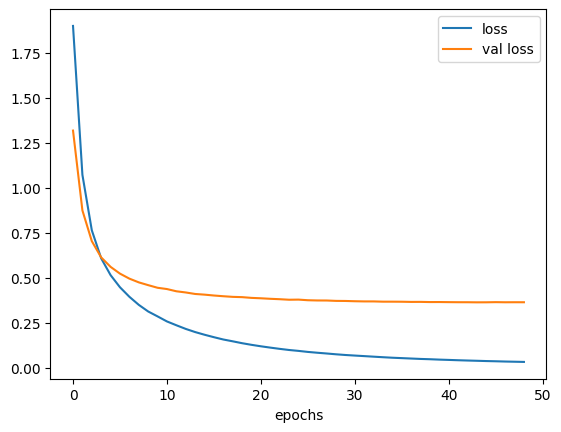

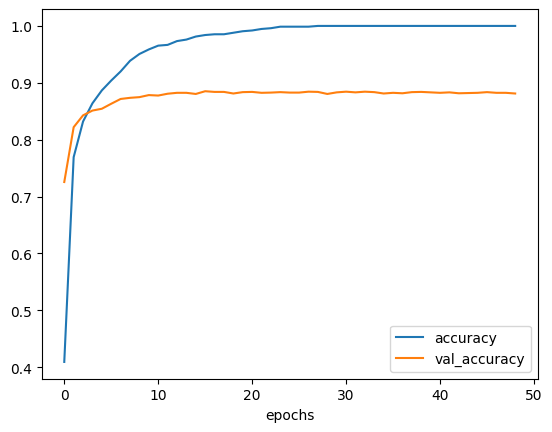

In [23]:
plot_loss_curves(efficientnet_history2)

In [55]:
#we can see there was really no improvement after epoch 15 or so.

### Types of transfer learning

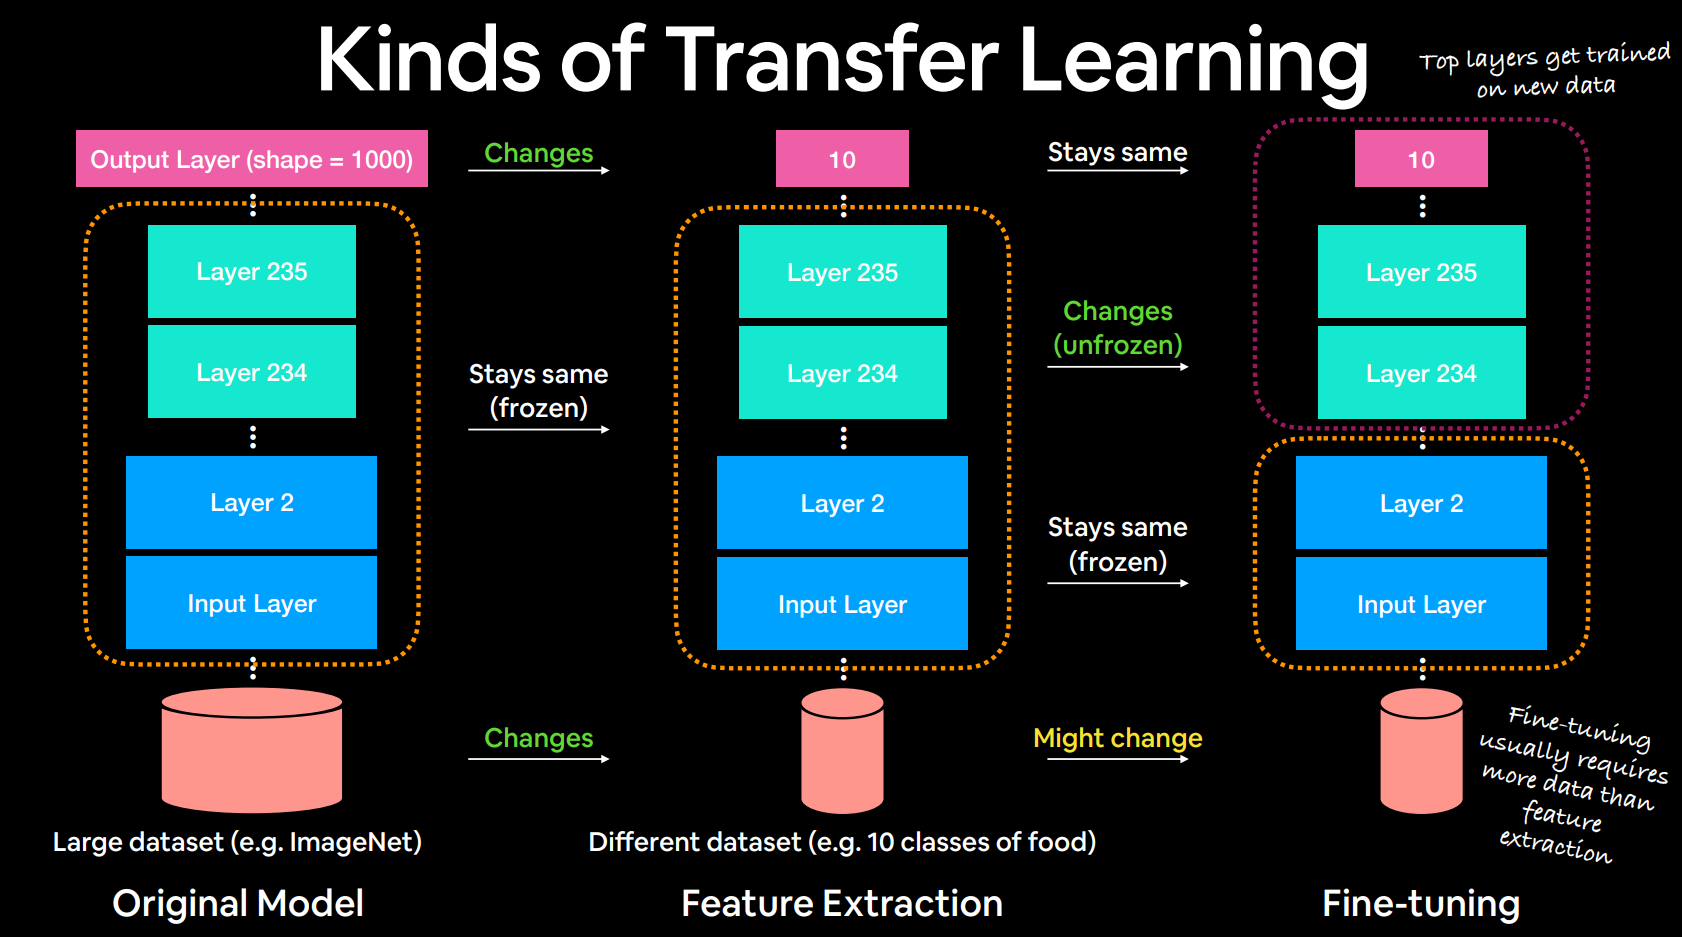

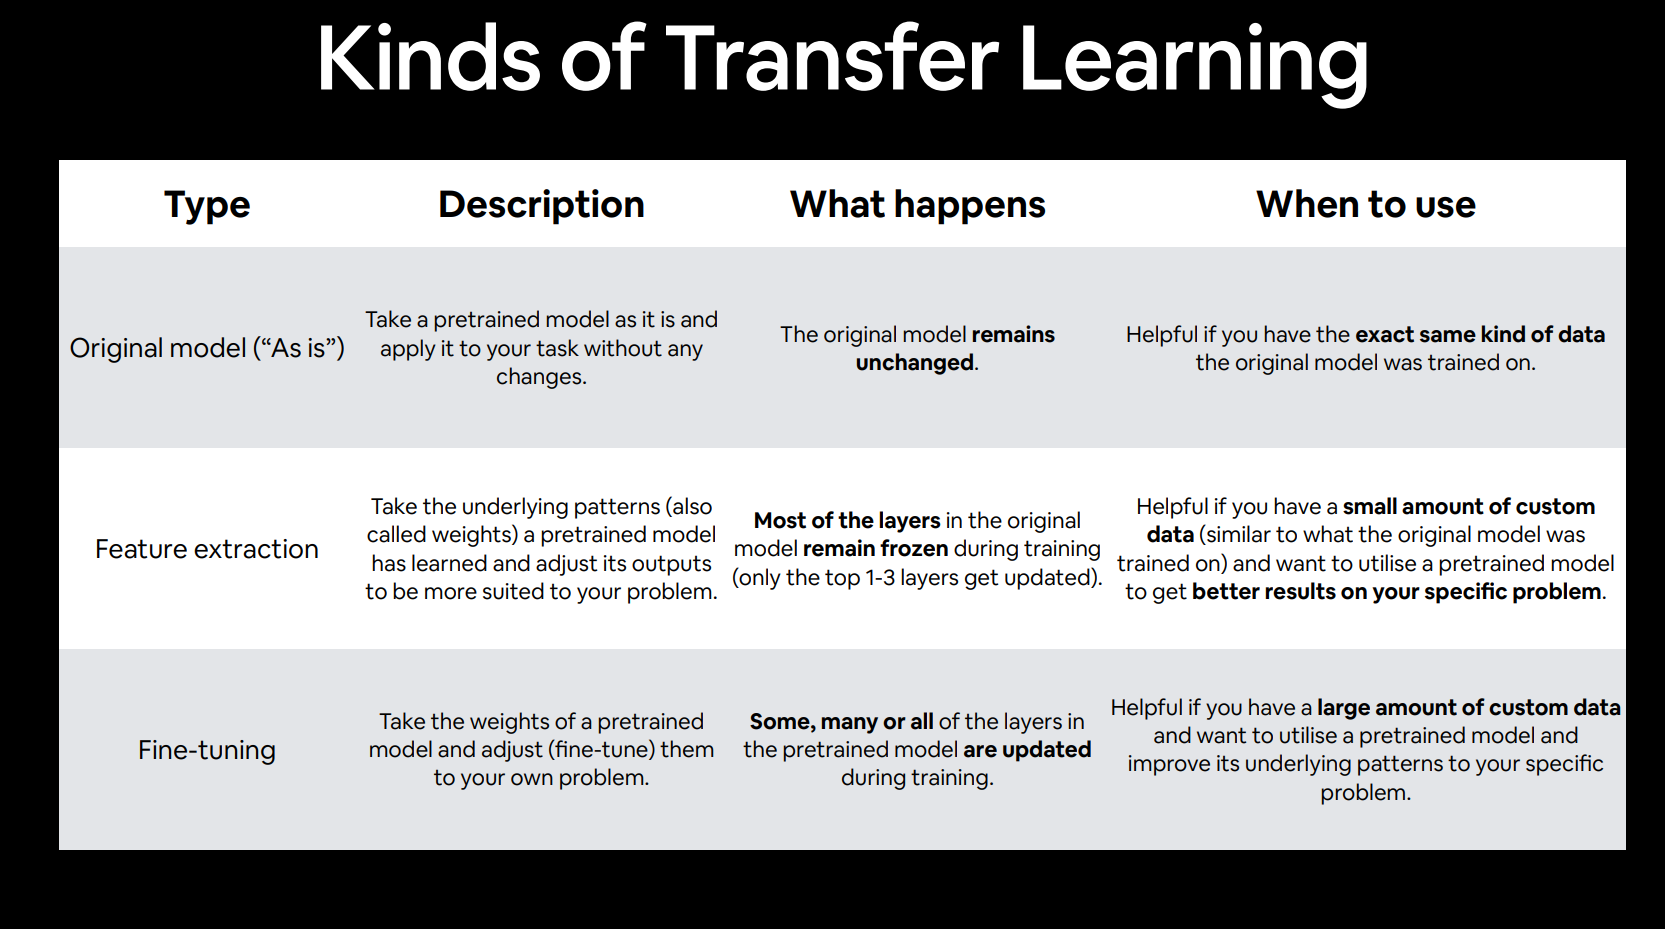

#### How many layers are in the efficientnet model?

In [59]:
efficientnet_model.layers[0].weights

[<tf.Variable 'stem_conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
       

In [62]:
len(efficientnet_model.layers[0].weights)
#estimate of tthe number of layers in efnet model

309

### Using Tensorboard to viz the results of the experiments

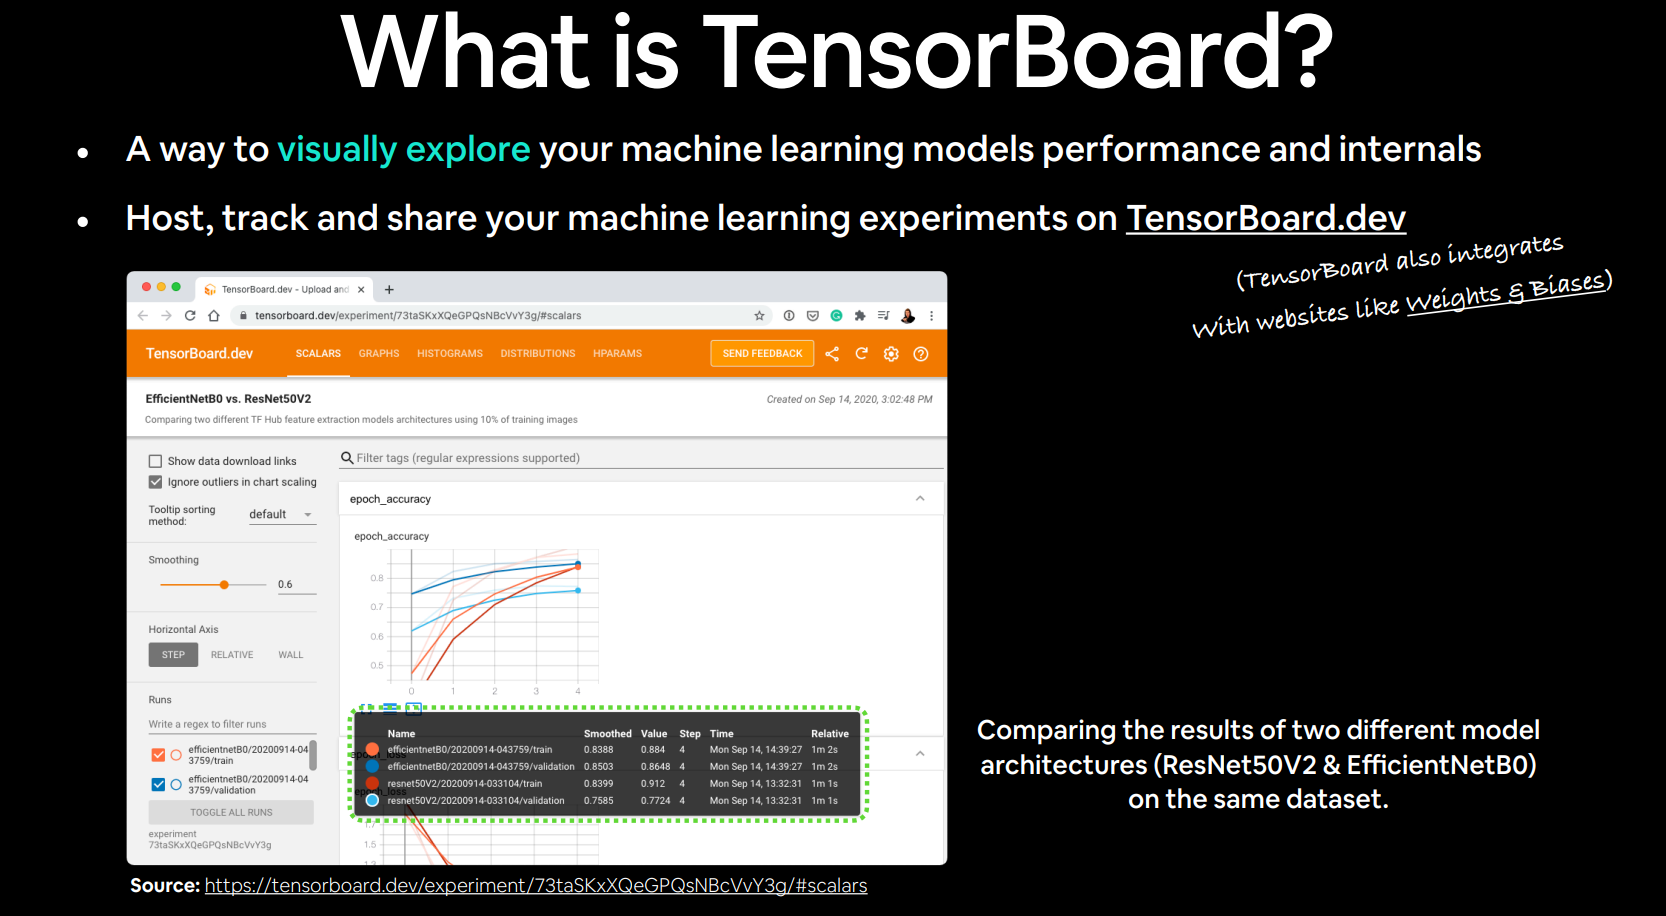

In [24]:
%load_ext tensorboard

In [25]:
%tensorboard --logdir hub/